# Exploring Cox Proportional Hazards Assumptions

There are 5 assumptions:
1. Proportional Hazards assumptions
2. Independence assumption
3. Linearity assumption
4. No multicollinearity assumption
5. No influential observations assumption

## Reading in the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Cox proportional Hazards
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [ ]:
df_pheno = pd.read_pickle('../../../D/2023-ca4021-bradyd-35-mcdaida-3/data/proc/pheno_imp.pkl') ## including GraftSurvivalDays and GraftCensored
df_clust = pd.read_pickle('../../../D/2023-ca4021-bradyd-35-mcdaida-3/data/proc/pheno_eng.pkl') ## Data diarmuid has cleaned but GraftSurvivalDays and GraftCensored has been removed
df_pheno.columns

Index(['RecId', 'DonId', 'GraftSurvivalDays', 'GraftCensored', 'RecAge',
       'DonAge', 'RecSex', 'DonSex', 'GraftNo', 'PrimaryRenalDisease',
       'HasDiabetes', 'eGFR1Year', 'eGFR5Year', 'RecPC1', 'RecPC2', 'RecPC3',
       'DonPC1', 'DonPC2', 'DonPC3', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'RecAlbuminuriaPRS', 'DonAlbuminuriaPRS',
       'ReceGFRPRS', 'DoneGFRPRS', 'ReceGFRDeltaPRS', 'DoneGFRDeltaPRS',
       'RecStrokePRS', 'DonStrokePRS', 'RecIAPRS', 'DonIAPRS', 'RecHAKVPRS',
       'DonHAKVPRS', 'RecPKDPRS', 'DonPKDPRS', 'RecKVPRS', 'DonKVPRS',
       'GraftDate', 'GraftType', 'OnDialysis', 'IntracranialHaemorrhage',
       'DonType', 'HLAMismatches', 'ColdIschemiaTime', 'RecSex_num',
       'DonSex_num', 'PrimaryRenalDisease_num', 'GraftType_num', 'source'],
      dtype='object')

In [ ]:
df_clust.columns

Index(['index', 'DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS',
       'ColdIschemiaTime', 'GraftNo'],
      dtype='object')

In [ ]:
df_clust.dtypes

index                        object
DonAge                      float64
RecAge                      float64
DonSex                     category
RecSex                     category
SexMismatch                    bool
Year                          int64
IntracranialHaemorrhage        bool
RecPC1                      float64
RecHypertensionPRS          float64
DonHypertensionPRS          float64
DoneGFRPRS                  float64
DonStrokePRS                float64
RecHAKVPRS                  float64
ColdIschemiaTime            float64
GraftNo                     float64
dtype: object

In [ ]:
### Adding index column to data with GraftSurvivalDays and GraftCensored
### Needed for joining GraftSurvivalDays and GraftCensored to the df_clust dataframe
df_pheno['index'] = df_pheno.index
col = df_pheno.pop('index')
df_pheno.insert(0, 'index', col)

## taking the index column, GraftSurvivalDays and GraftCensored column from the df_pheno
survival = df_pheno[['index', 'GraftSurvivalDays', 'GraftCensored']]

## Merging these columns into the predictive variables matching on index
df_survival = df_clust.merge(survival, on='index', how='left')
df_survival.dtypes

index                        object
DonAge                      float64
RecAge                      float64
DonSex                     category
RecSex                     category
SexMismatch                    bool
Year                          int64
IntracranialHaemorrhage        bool
RecPC1                      float64
RecHypertensionPRS          float64
DonHypertensionPRS          float64
DoneGFRPRS                  float64
DonStrokePRS                float64
RecHAKVPRS                  float64
ColdIschemiaTime            float64
GraftNo                     float64
GraftSurvivalDays           float64
GraftCensored               float64
dtype: object

In [ ]:
## Changing column RecSex/DonSex from category to type int
df_survival['DonSex'].replace(['Male', 'Female'], [0,1], inplace=True)
df_survival['RecSex'].replace(['Male', 'Female'], [0,1], inplace=True)
df_survival['DonSex'] = df_survival['DonSex'].astype(int)
df_survival['RecSex'] = df_survival['RecSex'].astype(int)
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878 entries, 0 to 1877
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    1878 non-null   object 
 1   DonAge                   1878 non-null   float64
 2   RecAge                   1878 non-null   float64
 3   DonSex                   1878 non-null   int64  
 4   RecSex                   1878 non-null   int64  
 5   SexMismatch              1878 non-null   bool   
 6   Year                     1878 non-null   int64  
 7   IntracranialHaemorrhage  1878 non-null   bool   
 8   RecPC1                   1878 non-null   float64
 9   RecHypertensionPRS       1878 non-null   float64
 10  DonHypertensionPRS       1878 non-null   float64
 11  DoneGFRPRS               1878 non-null   float64
 12  DonStrokePRS             1878 non-null   float64
 13  RecHAKVPRS               1878 non-null   float64
 14  ColdIschemiaTime        

## Running Cox Proportional Hazards Function

In [ ]:
cph = CoxPHFitter(alpha=0.5) ##95% confidence Interval
## Remove Index as not needed
x = df_survival.drop(['index'], axis = 1)
cph.fit(x, duration_col = 'GraftSurvivalDays', event_col = 'GraftCensored')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1878 total observations, 1497 right-censored observations>
             duration col = 'GraftSurvivalDays'
                event col = 'GraftCensored'
      baseline estimation = breslow
   number of observations = 1878
number of events observed = 381
   partial log-likelihood = -2562.88
         time fit was run = 2023-04-03 11:37:18 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 50%   coef upper 50%  exp(coef) lower 50%  exp(coef) upper 50%
covariate                                                                                                                       
DonAge                    0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
RecAge                   -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
DonSex                   -0.14       0.87       0.11            -0.21            -0.06                 0.81                 0.94
RecSex                   -0.03       0.97       0.11            -0.10             0.05                 0.90                 1.05
SexMismatch               0.06       1.06       0.11            -0.02             0.13                 0.98                 1.14
Year                     -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
IntracranialHaemorrhage  -0.05       0.95       0.12            -0.13             0.03                 0.88                 1.03
RecPC1                    9.85   18872.20       4.83             6.59            13.10               725.90             4.91e+05
RecHypertensionPRS       -0.02       0.98       0.05            -0.06             0.02                 0.95                 1.02
DonHypertensionPRS        0.02       1.02       0.05            -0.02             0.05                 0.98                 1.05
DoneGFRPRS               -0.05       0.95       0.05            -0.08            -0.01                 0.92                 0.99
DonStrokePRS             -0.06       0.94       0.05            -0.10            -0.03                 0.91                 0.97
RecHAKVPRS                0.09       1.10       0.05             0.06             0.13                 1.06                 1.14
ColdIschemiaTime          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
GraftNo                   0.54       1.71       0.15             0.44             0.64                 1.55                 1.89

                          cmp to     z      p   -log2(p)
covariate                                               
DonAge                      0.00  5.78 <0.005      26.97
RecAge                      0.00 -1.60   0.11       3.18
DonSex                      0.00 -1.23   0.22       2.19
RecSex                      0.00 -0.26   0.80       0.33
SexMismatch                 0.00  0.54   0.59       0.76
Year                        0.00 -0.71   0.48       1.06
IntracranialHaemorrhage     0.00 -0.39   0.70       0.52
RecPC1                      0.00  2.04   0.04       4.59
RecHypertensionPRS          0.00 -0.36   0.72       0.48
DonHypertensionPRS          0.00  0.30   0.76       0.39
DoneGFRPRS                  0.00 -0.90   0.37       1.44
DonStrokePRS                0.00 -1.21   0.22       2.16
RecHAKVPRS                  0.00  1.76   0.08       3.67
ColdIschemiaTime            0.00  0.60   0.55       0.87
GraftNo                     0.00  3.59 <0.005      11.54
---
Concordance = 0.62
Partial AIC = 5155.76
log-likelihood ratio test = 59.67 on 15 df
-log2(p) of ll-ratio test = 21.73

## Assumption 1: Can be tested using the Schoenfeld residuals test

In [ ]:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=x, kind='scaled_schoenfeld')
print(scaled_schoenfeld_residuals)

covariate    DonAge    RecAge    DonSex    RecSex  SexMismatch      Year  \
1859      -0.172226  0.013750 -0.813413 -0.971043     1.059081 -0.068051   
866       -0.026336  0.032457 -2.395535 -1.107804     1.071155  0.168216   
1729      -0.038434  0.047299 -2.657396  2.218803    -2.241685 -0.176330   
1784       0.026394 -0.098918 -2.020632  2.760804    -2.495821  0.081300   
1805       0.070728 -0.029867 -1.986507  2.528591    -2.450617 -0.198213   
...             ...       ...       ...       ...          ...       ...   
313       -0.110096  0.098962 -0.757043 -1.141192     0.923413  0.108160   
219        0.017659 -0.023347  2.812343  2.996355     2.682930 -0.035457   
1381      -0.028850 -0.027898 -1.670870 -0.984890     0.209731 -0.042041   
1510      -0.069533  0.099855  1.713363 -1.622781    -2.732358 -0.081647   
223        0.003947 -0.038510 -2.666909 -2.427520    -1.040102  0.003221   

covariate  IntracranialHaemorrhage      RecPC1  RecHypertensionPRS  \
1859             

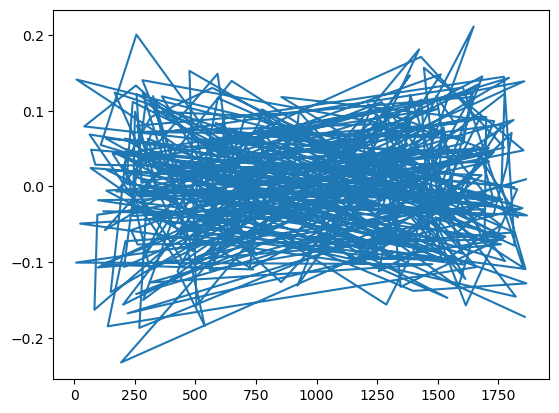

In [ ]:
# Plotting the residuals for donor age against time.

from matplotlib import pyplot as plt
 
plt.plot(scaled_schoenfeld_residuals.index, scaled_schoenfeld_residuals['DonAge'])
 
plt.show()

In [ ]:
#Run the CPHFitter.proportional_hazards_test on the scaled Schoenfeld residuals
proportional_hazard_test(fitted_cox_model=cph, training_df=x, time_transform='log', precomputed_residuals=scaled_schoenfeld_residuals)

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = log
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1878 total observations, 1497 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic    p  -log2(p)
ColdIschemiaTime                   0.75 0.39      1.37
DonAge                             0.97 0.33      1.62
DonHypertensionPRS                 3.80 0.05      4.29
DonSex                             0.30 0.58      0.78
DonStrokePRS                       1.58 0.21      2.26
DoneGFRPRS                         4.72 0.03      5.07
GraftNo                            0.05 0.83      0.27
IntracranialHaemorrhage            0.98 0.32      1.63
RecAge                             1.33 0.25      2.01
RecHAKVPRS                         1.69 0.19      2.37
RecHypertensionPRS                 2.90 0.09      3.50
RecPC1                             1.07 0.30      1.73
RecSex                             0.72 0.40      1.33
SexMismatch                        0.11 0.74      0.44
Year                               0.56 0.45      1.14

## Checking all 5 Assumptions using lifeline library

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1878 total observations, 1497 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic    p  -log2(p)
ColdIschemiaTime        km              0.01 0.93      0.11
                        rank            0.23 0.63      0.66
DonAge                  km              2.08 0.15      2.75
                        rank            1.72 0.19      2.40
DonHypertensionPRS      km              2.78 0.10      3.38
                        rank            3.56 0.06      4.08
DonSex                  km              0.04 0.84      0.24
                        rank            0.18 0.67      0.58
DonStrokePRS            km              0.98 0.32      1.64
                        rank            1.32 0.25      2.00
DoneGFRPRS              km              2.68 0.10      3.30
                        rank            4.92 0.03      5.23
GraftNo                 km              0.60 0.44      1.19
                        rank            0.22 0.64      0.65
IntracranialHaemorrhage km              1.06 0.30      1.72
                        rank            1.11 0.29      1.78
RecAge                  km              2.97 0.08      3.56
                        rank            2.93 0.09      3.52
RecHAKVPRS              km              0.76 0.38      1.38
                        rank            1.25 0.26      1.92
RecHypertensionPRS      km              0.81 0.37      1.44
                        rank            2.71 0.10      3.33
RecPC1                  km              1.21 0.27      1.88
                        rank            1.12 0.29      1.79
RecSex                  km              0.49 0.48      1.05
                        rank            0.83 0.36      1.47
SexMismatch             km              0.01 0.91      0.13
                        rank            0.03 0.87      0.20
Year                    km              0.63 0.43      1.23
                        rank            1.23 0.27      1.90



1. Variable 'DoneGFRPRS' failed the non-proportional test: p-value is 0.0266.

   Advice 1: the functional form of the variable 'DoneGFRPRS' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'DoneGFRPRS' using pd.cut, and then specify it in
`strata=['DoneGFRPRS', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/lat

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0266)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.1015)'>]]

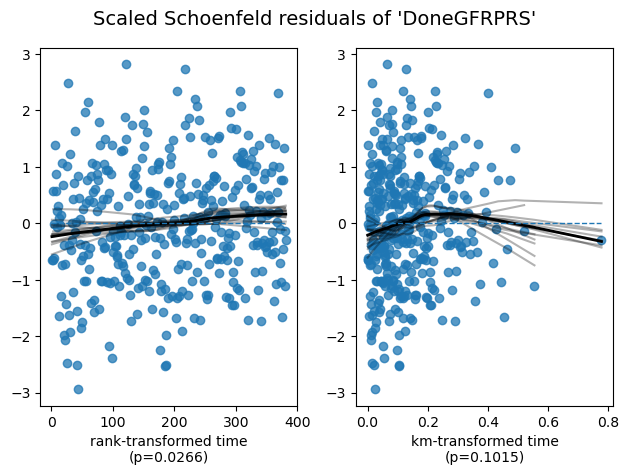

In [ ]:
cph.check_assumptions(x, p_value_threshold=0.05, show_plots=True)

### Trying binning with variable DoneGFRPRS

In [ ]:
df_survival['DoneGFRPRS'].min(), df_survival['DoneGFRPRS'].max()

(-2.85339817, 3.05540122)

In [ ]:
difference = df_survival['DoneGFRPRS'].max() - df_survival['DoneGFRPRS'].min()
difference

5.90879939

In [ ]:
df_bins = df_survival.copy()
df_bins['DoneGFRPRS_bins'] = pd.cut(df_bins['DoneGFRPRS'], bins=6)

df_bins[['DoneGFRPRS', 'DoneGFRPRS_bins']].head(20)

,DoneGFRPRS,DoneGFRPRS_bins
0,-0.068460,"(-0.884, 0.101]"
1,0.975353,"(0.101, 1.086]"
2,-0.613161,"(-0.884, 0.101]"
3,-0.446593,"(-0.884, 0.101]"
4,1.232662,"(1.086, 2.071]"
5,-0.284122,"(-0.884, 0.101]"
6,-0.235851,"(-0.884, 0.101]"
7,-0.235851,"(-0.884, 0.101]"
8,-1.156369,"(-1.869, -0.884]"
9,1.495004,"(1.086, 2.071]"


In [ ]:
df_bins.columns

Index(['index', 'DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS',
       'ColdIschemiaTime', 'GraftNo', 'GraftSurvivalDays', 'GraftCensored',
       'DoneGFRPRS_bins'],
      dtype='object')

In [ ]:
df_bins[['DoneGFRPRS', 'DoneGFRPRS_bins']].value_counts()

DoneGFRPRS  DoneGFRPRS_bins
 3.055401   (2.071, 3.055]     2
-0.209388   (-0.884, 0.101]    2
 0.477422   (0.101, 1.086]     2
 1.070028   (0.101, 1.086]     2
-0.189165   (-0.884, 0.101]    2
                              ..
-0.291200   (-0.884, 0.101]    1
-0.292193   (-0.884, 0.101]    1
-0.292365   (-0.884, 0.101]    1
-0.294579   (-0.884, 0.101]    1
 0.077447   (-0.884, 0.101]    1
Length: 1680, dtype: int64

In [ ]:
cph = CoxPHFitter(alpha=0.5) ##95% confidence Interval
x = df_bins.drop(['index', 'DoneGFRPRS'], axis=1)
cph.fit(x, duration_col = 'GraftSurvivalDays', event_col = 'GraftCensored', strata='DoneGFRPRS_bins')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1878 total observations, 1497 right-censored observations>
             duration col = 'GraftSurvivalDays'
                event col = 'GraftCensored'
                   strata = DoneGFRPRS_bins
      baseline estimation = breslow
   number of observations = 1878
number of events observed = 381
   partial log-likelihood = -1996.67
         time fit was run = 2023-04-03 11:37:44 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 50%   coef upper 50%  exp(coef) lower 50%  exp(coef) upper 50%
covariate                                                                                                                       
DonAge                    0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
RecAge                   -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
DonSex                   -0.12       0.89       0.11            -0.19            -0.04                 0.83                 0.96
RecSex                   -0.03       0.97       0.11            -0.10             0.05                 0.90                 1.05
SexMismatch               0.05       1.06       0.11            -0.02             0.13                 0.98                 1.14
Year                     -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
IntracranialHaemorrhage  -0.06       0.94       0.12            -0.14             0.02                 0.87                 1.02
RecPC1                    9.94   20745.18       4.88             6.65            13.23               772.64             5.57e+05
RecHypertensionPRS       -0.01       0.99       0.05            -0.05             0.02                 0.95                 1.02
DonHypertensionPRS        0.01       1.01       0.05            -0.02             0.04                 0.98                 1.05
DonStrokePRS             -0.07       0.93       0.05            -0.10            -0.03                 0.90                 0.97
RecHAKVPRS                0.09       1.10       0.05             0.06             0.13                 1.06                 1.14
ColdIschemiaTime          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
GraftNo                   0.52       1.68       0.15             0.42             0.62                 1.52                 1.86

                          cmp to     z      p   -log2(p)
covariate                                               
DonAge                      0.00  5.75 <0.005      26.70
RecAge                      0.00 -1.65   0.10       3.33
DonSex                      0.00 -1.03   0.30       1.73
RecSex                      0.00 -0.25   0.81       0.31
SexMismatch                 0.00  0.49   0.62       0.68
Year                        0.00 -0.52   0.60       0.73
IntracranialHaemorrhage     0.00 -0.51   0.61       0.72
RecPC1                      0.00  2.04   0.04       4.59
RecHypertensionPRS          0.00 -0.23   0.82       0.29
DonHypertensionPRS          0.00  0.20   0.84       0.25
DonStrokePRS                0.00 -1.32   0.19       2.43
RecHAKVPRS                  0.00  1.77   0.08       3.70
ColdIschemiaTime            0.00  0.54   0.59       0.76
GraftNo                     0.00  3.44 <0.005      10.74
---
Concordance = 0.60
Partial AIC = 4021.34
log-likelihood ratio test = 57.36 on 14 df
-log2(p) of ll-ratio test = 21.50

## Checking assumptions again after binning is performed

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1878 total observations, 1497 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic    p  -log2(p)
ColdIschemiaTime        km              0.06 0.80      0.31
                        rank            1.10 0.29      1.77
DonAge                  km              1.74 0.19      2.41
                        rank            0.51 0.48      1.07
DonHypertensionPRS      km              2.91 0.09      3.50
                        rank            0.03 0.87      0.20
DonSex                  km              0.11 0.75      0.42
                        rank            1.54 0.21      2.22
DonStrokePRS            km              2.18 0.14      2.84
                        rank            1.43 0.23      2.11
GraftNo                 km              0.22 0.64      0.65
                        rank            0.15 0.70      0.52
IntracranialHaemorrhage km              0.50 0.48      1.07
                        rank            0.02 0.88      0.19
RecAge                  km              3.24 0.07      3.80
                        rank            3.75 0.05      4.24
RecHAKVPRS              km              1.97 0.16      2.64
                        rank            3.63 0.06      4.14
RecHypertensionPRS      km              0.78 0.38      1.41
                        rank            1.18 0.28      1.85
RecPC1                  km              1.22 0.27      1.90
                        rank            0.00 0.99      0.02
RecSex                  km              1.31 0.25      1.99
                        rank            4.27 0.04      4.69
SexMismatch             km              0.10 0.76      0.40
                        rank            0.51 0.48      1.07
Year                    km              0.45 0.50      0.99
                        rank            2.88 0.09      3.48



1. Variable 'RecAge' failed the non-proportional test: p-value is 0.0528.

   Advice 1: the functional form of the variable 'RecAge' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'RecAge' using pd.cut, and then specify it in
`strata=['RecAge', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'RecSex' failed the non-proportional test: p-value is 0.0387.

   Advice: with so few unique values (only 2), you can include `strata=['RecSex', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.rea

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0528)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0719)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0387)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.2526)'>]]

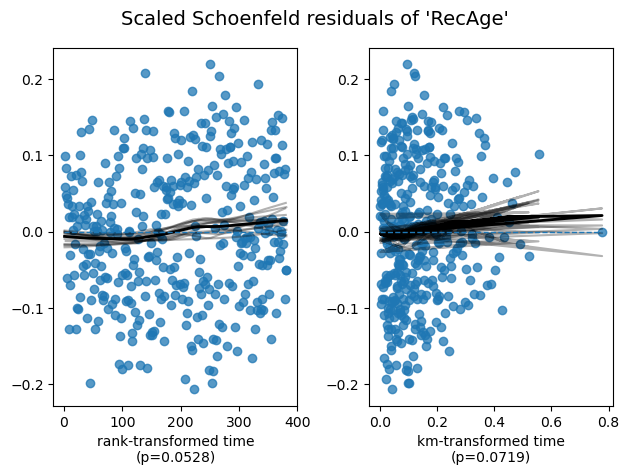

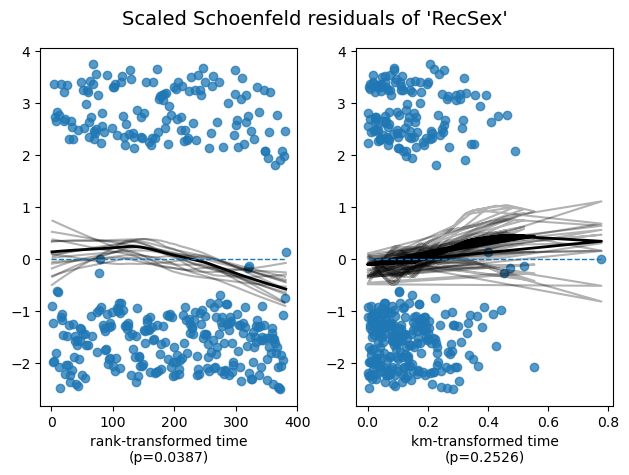

In [ ]:
cph.check_assumptions(x, p_value_threshold=0.05, show_plots=True)

### Performing binning on RecAge

In [ ]:
df_survival['RecAge'].min(), df_survival['RecAge'].max()

(18.0, 79.0)

In [ ]:
difference = df_survival['RecAge'].max() - df_survival['RecAge'].min()
difference

61.0

In [ ]:
df_bins['RecAge_bins'] = pd.cut(df_bins['RecAge'], bins=12)

df_bins[['RecAge', 'RecAge_bins']].head(20)

,RecAge,RecAge_bins
0,54.0,"(53.583, 58.667]"
1,35.0,"(33.25, 38.333]"
2,53.0,"(48.5, 53.583]"
3,33.0,"(28.167, 33.25]"
4,61.0,"(58.667, 63.75]"
5,45.0,"(43.417, 48.5]"
6,38.0,"(33.25, 38.333]"
7,65.0,"(63.75, 68.833]"
8,28.0,"(23.083, 28.167]"
9,53.0,"(48.5, 53.583]"


In [ ]:
df_bins.columns

Index(['index', 'DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS',
       'ColdIschemiaTime', 'GraftNo', 'GraftSurvivalDays', 'GraftCensored',
       'DoneGFRPRS_bins', 'RecAge_bins'],
      dtype='object')

In [ ]:
cph = CoxPHFitter(alpha=0.5) ##95% confidence Interval
x = df_bins.drop(['index', 'RecAge', 'DoneGFRPRS'], axis=1)
cph.fit(x, duration_col = 'GraftSurvivalDays', event_col = 'GraftCensored', strata=['RecAge_bins', 'DoneGFRPRS_bins'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1878 total observations, 1497 right-censored observations>
             duration col = 'GraftSurvivalDays'
                event col = 'GraftCensored'
                   strata = ['RecAge_bins', 'DoneGFRPRS_bins']
      baseline estimation = breslow
   number of observations = 1878
number of events observed = 381
   partial log-likelihood = -1121.11
         time fit was run = 2023-04-03 11:38:05 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 50%   coef upper 50%  exp(coef) lower 50%  exp(coef) upper 50%
covariate                                                                                                                       
DonAge                    0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
DonSex                   -0.17       0.84       0.12            -0.25            -0.09                 0.78                 0.91
RecSex                   -0.03       0.97       0.11            -0.11             0.04                 0.90                 1.04
SexMismatch               0.11       1.11       0.12             0.03             0.19                 1.03                 1.21
Year                     -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
IntracranialHaemorrhage  -0.13       0.88       0.13            -0.21            -0.04                 0.81                 0.96
RecPC1                    9.18    9664.74       4.94             5.85            12.51               345.92             2.70e+05
RecHypertensionPRS       -0.01       0.99       0.06            -0.05             0.03                 0.95                 1.03
DonHypertensionPRS        0.03       1.03       0.05            -0.01             0.07                 0.99                 1.07
DonStrokePRS             -0.03       0.97       0.05            -0.07             0.00                 0.93                 1.00
RecHAKVPRS                0.10       1.10       0.06             0.06             0.14                 1.06                 1.15
ColdIschemiaTime          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
GraftNo                   0.52       1.69       0.16             0.42             0.63                 1.52                 1.88

                          cmp to     z      p   -log2(p)
covariate                                               
DonAge                      0.00  5.67 <0.005      26.10
DonSex                      0.00 -1.44   0.15       2.73
RecSex                      0.00 -0.29   0.77       0.37
SexMismatch                 0.00  0.93   0.35       1.49
Year                        0.00 -0.22   0.83       0.28
IntracranialHaemorrhage     0.00 -1.02   0.31       1.70
RecPC1                      0.00  1.86   0.06       3.99
RecHypertensionPRS          0.00 -0.16   0.88       0.19
DonHypertensionPRS          0.00  0.57   0.57       0.81
DonStrokePRS                0.00 -0.65   0.51       0.96
RecHAKVPRS                  0.00  1.74   0.08       3.60
ColdIschemiaTime            0.00  0.58   0.56       0.82
GraftNo                     0.00  3.28 <0.005       9.93
---
Concordance = 0.61
Partial AIC = 2268.23
log-likelihood ratio test = 54.38 on 13 df
-log2(p) of ll-ratio test = 20.88

In [ ]:
cph.check_assumptions(x, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


[]

# Random Survival Forest

In [ ]:
from sklearn.model_selection import train_test_split
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
%matplotlib inline

In [ ]:
df_bins.columns

Index(['index', 'DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS',
       'ColdIschemiaTime', 'GraftNo', 'GraftSurvivalDays', 'GraftCensored',
       'DoneGFRPRS_bins', 'RecAge_bins'],
      dtype='object')

In [ ]:
# Preparing data
#x = df_bins.drop(['index', 'RecAge_bins', 'DoneGFRPRS_bins'], axis=1)

# Building training and testing sets #
#N = 1000

#index_train, index_test = train_test_split( range(N), test_size = 0.2)
#data_train = x.loc[index_train].reset_index( drop = True )
#data_test  = x.loc[index_test].reset_index( drop = True )

In [ ]:
#features = x.drop(['GraftSurvivalDays', 'GraftCensored'], axis = 1)
# Creating the X, T and E input
#X_train, X_test = data_train[features.columns], data_test[features.columns]
#T_train, T_test = data_train['GraftSurvivalDays'].values, data_test['GraftSurvivalDays'].values
#E_train, E_test = data_train['GraftCensored'].values, data_test['GraftCensored'].values

In [ ]:
#### 4 - Creating an instance of the Conditional model and fitting the data.
# Building the model
#rsf = RandomSurvivalForestModel(num_trees=200)
#rsf.fit(X_train, T_train, E_train,
#        max_features="sqrt", max_depth=5, min_node_size=20)

In [ ]:
#### 5 - Cross Validation / Model Performances
#c_index = concordance_index(rsf, X_test, T_test, E_test) #0.81
#print('C-index: {:.2f}'.format(c_index))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = df_bins.drop(['index', 'RecAge_bins', 'DoneGFRPRS_bins'], axis=1)

train_data, test_data = train_test_split(x, test_size=0.2, random_state=25)

## train_data and test_data still include the target features
features = x.drop(['GraftSurvivalDays', 'GraftCensored'], axis = 1)

In [ ]:
X_train, X_test = train_data[features.columns], test_data[features.columns]
T_train, T_test = train_data['GraftSurvivalDays'], test_data['GraftSurvivalDays']
E_train, E_test = train_data['GraftCensored'], test_data['GraftCensored']

In [ ]:
## Creating an instance of the Conditional model and fitting the data.
# Building the model
rsf = RandomSurvivalForestModel(num_trees=100)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

RandomSurvivalForestModel

In [ ]:
#### 5 - Cross Validation / Model Performances
c_index = concordance_index(rsf, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

# XGBoost survival model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

In [ ]:
x = df_bins.drop(['index', 'RecAge_bins', 'DoneGFRPRS_bins'], axis=1)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x.drop(['GraftSurvivalDays', 'GraftCensored'], axis=1), 
                                                    x[['GraftSurvivalDays', 'GraftCensored']], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
# Define the survival analysis objective function
objective = 'survival:cox'

# Define the target features
y_train_tuple = xgb.DMatrix(y_train['GraftSurvivalDays'], y_train['GraftCensored'])

In [ ]:
# Train the XGBoost survival model
model = xgb.XGBSurvivalModel(objective=objective, learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train_tuple)

AttributeError: module 'xgboost' has no attribute 'XGBSurvivalModel'